# Quantitative Trading Model based on Financial Market Sentiment / 基于市场情绪平稳度的量化交易模型

## Abstract / 概要

Based on the Efficient-market hypothesis (EFH), the stock price reflects all the available information, such as the piece of news published in a newspaper, which makes it extremely hard to predict the stock trend. This notebook has introduced a quantitative trading model based on financial market sentiment.

根据有效市场假说（EFH），股票指数的涨跌会受到新闻消息的刺激，从而使得较长期的股票指数预测较为困难。为了解决此问题，本文构建一个基于市场情绪平稳度的量化交易模型。

## Methodology / 方法

### Data Preparation / 数据准备

First and foremost, we will declare the constants to be used for the quantitative trading model, which are demonstrated as follows.
- `OBSERVATION_WINDOW_SIZE`: The observation window size is the period of time which is used to estimate the financial market sentiment. Based on the research, we will choose the first 50 min after the market is open as the observation window size.
- `MARKET_SENTIMENT_THRESHOLD`: The market sentiment threshold is defined as a standard of the volatility of the stock market. Specifically, if the market sentiment is larger than the threshold, then we can say that the stock market is volatile. Otherwise, the stock market is considered to be stable, and suitable for further transactions.
- `STOP_LOSS_THRESHOLD`: The stop-loss threshold is defined as a standard showing whether an action shall be performed to stop-loss. Specifically, if the stop-loss ratio is larger than the threshold, then we shall sell the stock to stop-loss. Otherwise, we may hold the stock until the market is closed.

首先，我们需要定义量化交易模型所需的常量。
- `OBSERVATION_WINDOW_SIZE`: 观察窗口用来判断当前市场情绪平稳度。根据经验调查，我们选取开盘之后的50分钟作为观察窗口。
- `MARKET_SENTIMENT_THRESHOLD`: 市场情绪平稳度阈值用来描述市场的趋势相对于噪声的程度，即平稳度，从而判断当日是否具有开仓条件。例如，若市场情绪平稳度指标小于阈值，则说明当日行情趋势明显，可以开仓。若情绪平稳度指标大于阈值，则说明当日行情震荡，趋势难以把握，从而放弃开仓。
- `STOP_LOSS_THRESHOLD`: 止损阈值用来描述是否需要采取措施平仓止损。例如，若开盘之后损失超过止损阈值，则选择平仓止损，反之则 一直持有仓位至收盘平仓。

In [0]:
"""
Constants
"""
# 情绪平稳度观察窗口 Observation window size after market open
OBSERVATION_WINDOW_SIZE = 200

# 情绪平稳度阈值 Market sentiment threshold
# If market sentiment >= threshold, then the stock market is volatile
# If market sentiment < threshold, then the stock market is stable
MARKET_SENTIMENT_THRESHOLD = 0.0009

# 止损阈值 Stop-loss threshold
# If loss >= threshold, then sell the stock to stop-loss
# If loss < threshold, then hold the stock until market close
STOP_LOSS_THRESHOLD = 0.05

Then, let's create some fake stock price data for demonstration purpose, and show the data in the diagram below.

其次，为了演示目的，我们创建一些假的股票数据，并且用以下图表展示出来。

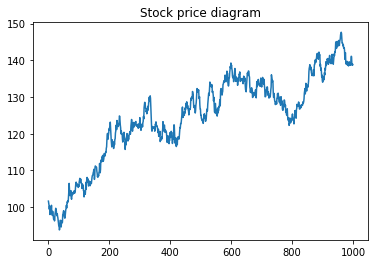

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Create fake stock price data
np.random.seed(1)
a = np.random.randn(1000)
prices = np.cumsum(a) + 100

# Show diagram
plt.title('Stock price diagram')
plt.plot(prices)
plt.show()

We will choose the stock price within the first 50 min after the market is open as the observation window, which is used to determine the financial market sentiment.

我们会选取开盘后50分钟的股票指数作为观察窗口，以此判断当前市场情绪平稳度。

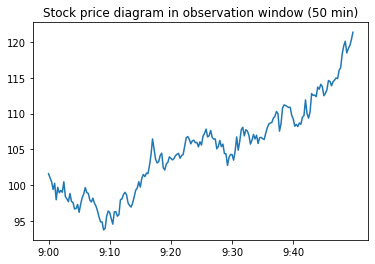

In [3]:
# Pick up the stock price in the observation window
sample_prices = prices[:OBSERVATION_WINDOW_SIZE]

# Show diagram
x = ['9:00', '9:10', '9:20', '9:30', '9:40']
step = OBSERVATION_WINDOW_SIZE / len(x)
x_loc = np.arange(0, OBSERVATION_WINDOW_SIZE, step=step)

plt.title('Stock price diagram in observation window (50 min)')
plt.plot(sample_prices)
plt.xticks(x_loc, x)
plt.show()

### Financial Market Sentiment / 市场情绪平稳度

The maximum drawdown is used to measure the maximum decline from a historical peak, which is calculated in the formula below.

最大回撤用来衡量产品净值走到最低点时的收益率回撤幅度的最大值，其公式如下。

$MaxDrawdown = \max ( \frac{P_{PrevMax} - P_{Current}}{P_{PrevMax}})$

We will then calculate the average maximum drawdown with the following formula.

我们用以下公式计算平均最大回撤。

$AvgMaxDrawdown = \frac{1}{n}MaxDrawdown$

In [4]:
import sys
import pandas as pd

def calculate_drawdown(prices):
    """
    Calculate max drawdown of stock market
    """
    prices = pd.Series(prices)
    cummax = prices.cummax()
    drawdown = (cummax - prices) / cummax
    return drawdown

# Calculate max drawdown
drawdown = calculate_drawdown(sample_prices)
max_drawdown = max(drawdown)
print('Max drawdown: {}'.format(max_drawdown))

# Calculate averate max drawdown
avg_max_drawdown = max_drawdown / OBSERVATION_WINDOW_SIZE
print('Average max drawdown: {}'.format(avg_max_drawdown))

Max drawdown: 0.07719140875004761
Average max drawdown: 0.00038595704375023806


Then, we will also calculate the maximum reverse drawdown, which measures the maximum increase from a historical valley floor.

我们亦会通过计算最大反向回撤来衡量产品净值走到最高点时的收益率反向回撤幅度的最大值。

$MaxReverseDrawdown = \max ( \frac{P_{Current} - P_{PrevMin}}{P_{PrevMin}})$

We will then calculate the average maximum reverse drawdown with the following formula.

我们用以下公式计算平均最大反向回撤。

$AvgMaxReverseDrawdown = \frac{1}{n}MaxReverseDrawdown$

In [5]:
def calculate_reverse_drawdown(prices):
    """
    Calculate reverse max drawdown of stock market
    """
    prices = pd.Series(prices)
    cummin = prices.cummin()
    reverse_drawdown = (prices - cummin) / cummin
    return reverse_drawdown

reverse_drawdown = calculate_reverse_drawdown(sample_prices)
max_reverse_drawdown = max(reverse_drawdown)
print('Max reverse drawdown: {}'.format(max_reverse_drawdown))

avg_max_reverse_drawdown = max_reverse_drawdown / OBSERVATION_WINDOW_SIZE
print('Average max reverse drawdown: {}'.format(avg_max_reverse_drawdown))

Max reverse drawdown: 0.29385793539668315
Average max reverse drawdown: 0.0014692896769834156


Then, let's show the diagram with the above figures.

我们将观察窗口内的股票指数，股票指数各点回撤以及反向回撤用下图来表示。

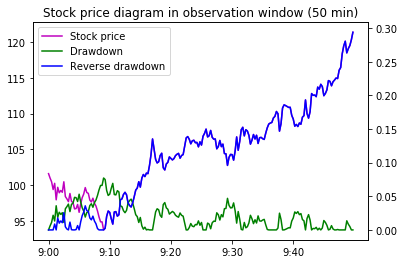

In [6]:
_, ax1 = plt.subplots()

line1 = ax1.plot(sample_prices, color='m', label = 'Stock price')

ax2 = ax1.twinx()

line2 = ax2.plot(drawdown, color='g', label = 'Drawdown')
line3 = ax2.plot(reverse_drawdown, color='b', label = 'Reverse drawdown')

lines = line1 + line2 + line3
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc=0)

plt.title('Stock price diagram in observation window (50 min)')
plt.xticks(x_loc, x)
plt.show()

Next, we will need to calculate the financial market sentiment, which chooses the smaller one between the average maximum drawdown and average maximum reverse drawdown.

其次，我们定义市场情绪平稳度为最大回撤均值和最大反向回撤均值中较小的值，该指标可以完美地描述一段时间序列的平稳度。

$MarketSentiment = \min (AvgMaxDrawdown, AvgMaxReverseDrawdown)$

In [7]:
market_sentiment = min(avg_max_drawdown, avg_max_reverse_drawdown)
print('Market sentiment: {}'.format(market_sentiment))

Market sentiment: 0.00038595704375023806


### Profit Calculation / 收益计算

Finally, we will calculate the profit based on the financial market sentiment. If the financial market sentiment is larger than the threshold, then we will not open a position, as the stock market is considered to be volatile. Otherwise, we will open a position as the stock market is stable enough. 

Then, we will compare the current price with the initial price when the market is open. If the current price is larger than the initial price, we can say that the stock price is increasing, and therefore we may choose to purchase the stock.

Furthermore, if the stop-loss rate is larger than the threshold, we will sell the stock immediately to stop-loss. Otherwise, we will not sell the stock and calculate the profit until the transaction market is closed.

最后，我们基于市场情绪平稳度来计算收益。若市场情绪平稳度大于阈值，我们可认为当日行情较为震荡，故放弃开仓。反之，若市场情绪平稳度小于阈值，我们可认为当日行情较为平稳，故可以考虑开仓。

其次，我们判断当天趋势的方向。若当前股票指数高于开盘价，即可预测当日趋势向上，在市场平稳的情况下可做多。反之，若当前股票指数低于开盘价，即可预测当日趋势向下，在市场平稳的情况下可做空。

此外，若开盘之后损失超过止损阈值，则选择平仓止损，反之则一直持有仓位至收盘平仓。

In [8]:
if market_sentiment >= MARKET_SENTIMENT_THRESHOLD:
    print('The stock market is volatile, therefore will not open a position')
else:
    print('The stock market is stable')
    initial_price = sample_prices[0]
    current_price = sample_prices[OBSERVATION_WINDOW_SIZE - 1]
    print('Initial price: {}, current price: {}'.format(initial_price, current_price))

    if initial_price < current_price:
        
        print('The stock price is increasing. Let\'s purchase the stock.')
        
        # Get stock price after the observation window
        prices_after_window = prices[OBSERVATION_WINDOW_SIZE:]
        profit = prices_after_window[len(prices_after_window) - 1] - current_price

        for price in prices_after_window:
            if price < current_price:
                loss = current_price - price
                loss_rate = loss / current_price
                if loss_rate >= STOP_LOSS_THRESHOLD:
                    print('Stop loss by selling the stock. Loss: {}, Loss Rate: {}'.format(loss, loss_rate))
                    profit = price - current_price
                    break

        print('Total profit: {}'.format(profit))

The stock market is stable
Initial price: 101.62434536366324, current price: 121.3377629695897
The stock price is increasing. Let's purchase the stock.
Total profit: 17.47471319001201


## Conclusion / 结论

To put it in a nutshell, we use the minimum value of the average maximum drawdown and the average maximum reverse drawdown to create a quantitative trading model based on financial market sentiment.

我们用最大回撤均值和最大反向回撤均值中较小的值作为市场情绪平稳度，从而计算股票指数收益。